# Обнаружение аномалий во временных рядах с использованием LSTM-автоэнкодеров на PyTorch

Лабораторная работа основана на материалах [этого блокнота](https://colab.research.google.com/github/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb).

## Задание
Обучите LSTM-автоэнкодер на датасете [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat) (либо любом другом интересном вам датасете). Удобно использовать подвыборку Arrhythmia Dataset (Physionet's MIT-BIH Arrhythmia Dataset - файлы `mitbih_train.csv`, `mitbih_test.csv`).

Загрузку данных удобно сделать с помощью pd.read_csv:
`train = pd.read_csv("mitbih_train.csv", header=None)`

В последнем столбце csv-файлов содержатся метки классов.

Для ускорения обучения задайте батч большого размера.

Покажите различия в ошибке реконструкции на нормальных и аномальных данных.

Можно модифицировать архитектуру модели, добавить предварительное масштабирование данных (например, minmax scaling transform, если ваши данные это требуют), попробовать поработать с многоканальными данными.

In [200]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F

In [108]:
def load_data(file):
    data = pd.read_csv(file, header=None)
    return data

In [109]:
df_train_val = load_data('/kaggle/input/heartbeat/mitbih_train.csv')
df_test = load_data('/kaggle/input/heartbeat/mitbih_test.csv')

In [19]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

В этом уроке вы научитесь обнаруживать аномалии во временных рядах с использованием LSTM-автоэнкодеров. В качестве примера используются реальные данные ЭКГ от одного пациента с сердечными заболеваниями для выявления ненормальных сердечных циклов.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

К концу этого урока вы научитесь:

- Подготавливать набор данных для обнаружения аномалий во временных рядах
- Создавать LSTM-автоэнкодер с помощью PyTorch
- Обучать и оценивать вашу модель
- Выбирать порог для обнаружения аномалий
- Классифицировать новые примеры как нормальные или аномальные

## Данные

[Датасет](http://timeseriesclassification.com/description.php?Dataset=ECG5000) содержит 5000 записей временных рядов (полученных с помощью ЭКГ) с 140 временными отсчетами. Каждая последовательность соответствует одному сердечному циклу одного пациента с хронической сердечной недостаточностью.


В датасете представлены 5 типов сердцебиений (классов):

- Нормальное (Normal - N)
- Преждевременное желудочковое сокращение R-на-T (R-on-T Premature Ventricular Contraction - R-on-T PVC)
- Преждевременное желудочковое сокращение - (Premature Ventricular Contraction - PVC)
- Суправентрикулярное преждевременное или экстопическое сокращение (Supra-ventricular Premature или Ectopic Beat - SP или EB)
- Неклассифицированный удар (Unclassified Beat - UB).

> Предполагая, что сердце здорово и типичный ритм составляет 70–75 ударов в минуту, каждый сердечный цикл занимает около 0,8 секунды; при частоте 60–100 ударов в минуту - 0,6–1 секунду [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

Датасет доступен на Google Drive. Загрузим данные:

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
CLASS_NORMAL = 0

class_names = ['N','S','V','F','Q']

Затем переименуем последний столбец в `target`, чтобы было проще к нему обращаться:

In [111]:
new_columns = list(df_train_val.columns)
new_columns[-1] = 'target'
df_train_val.columns = new_columns
df_test.columns = new_columns

In [112]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,target
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Исследовательский анализ данных (Exploratory Data Analysis)

Давайте проверим, сколько примеров для каждого класса сердцебиения у нас есть:

In [113]:
df_train_val.target.value_counts()

target
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Построим график результатов:

In [114]:
class_names

['N', 'S', 'V', 'F', 'Q']

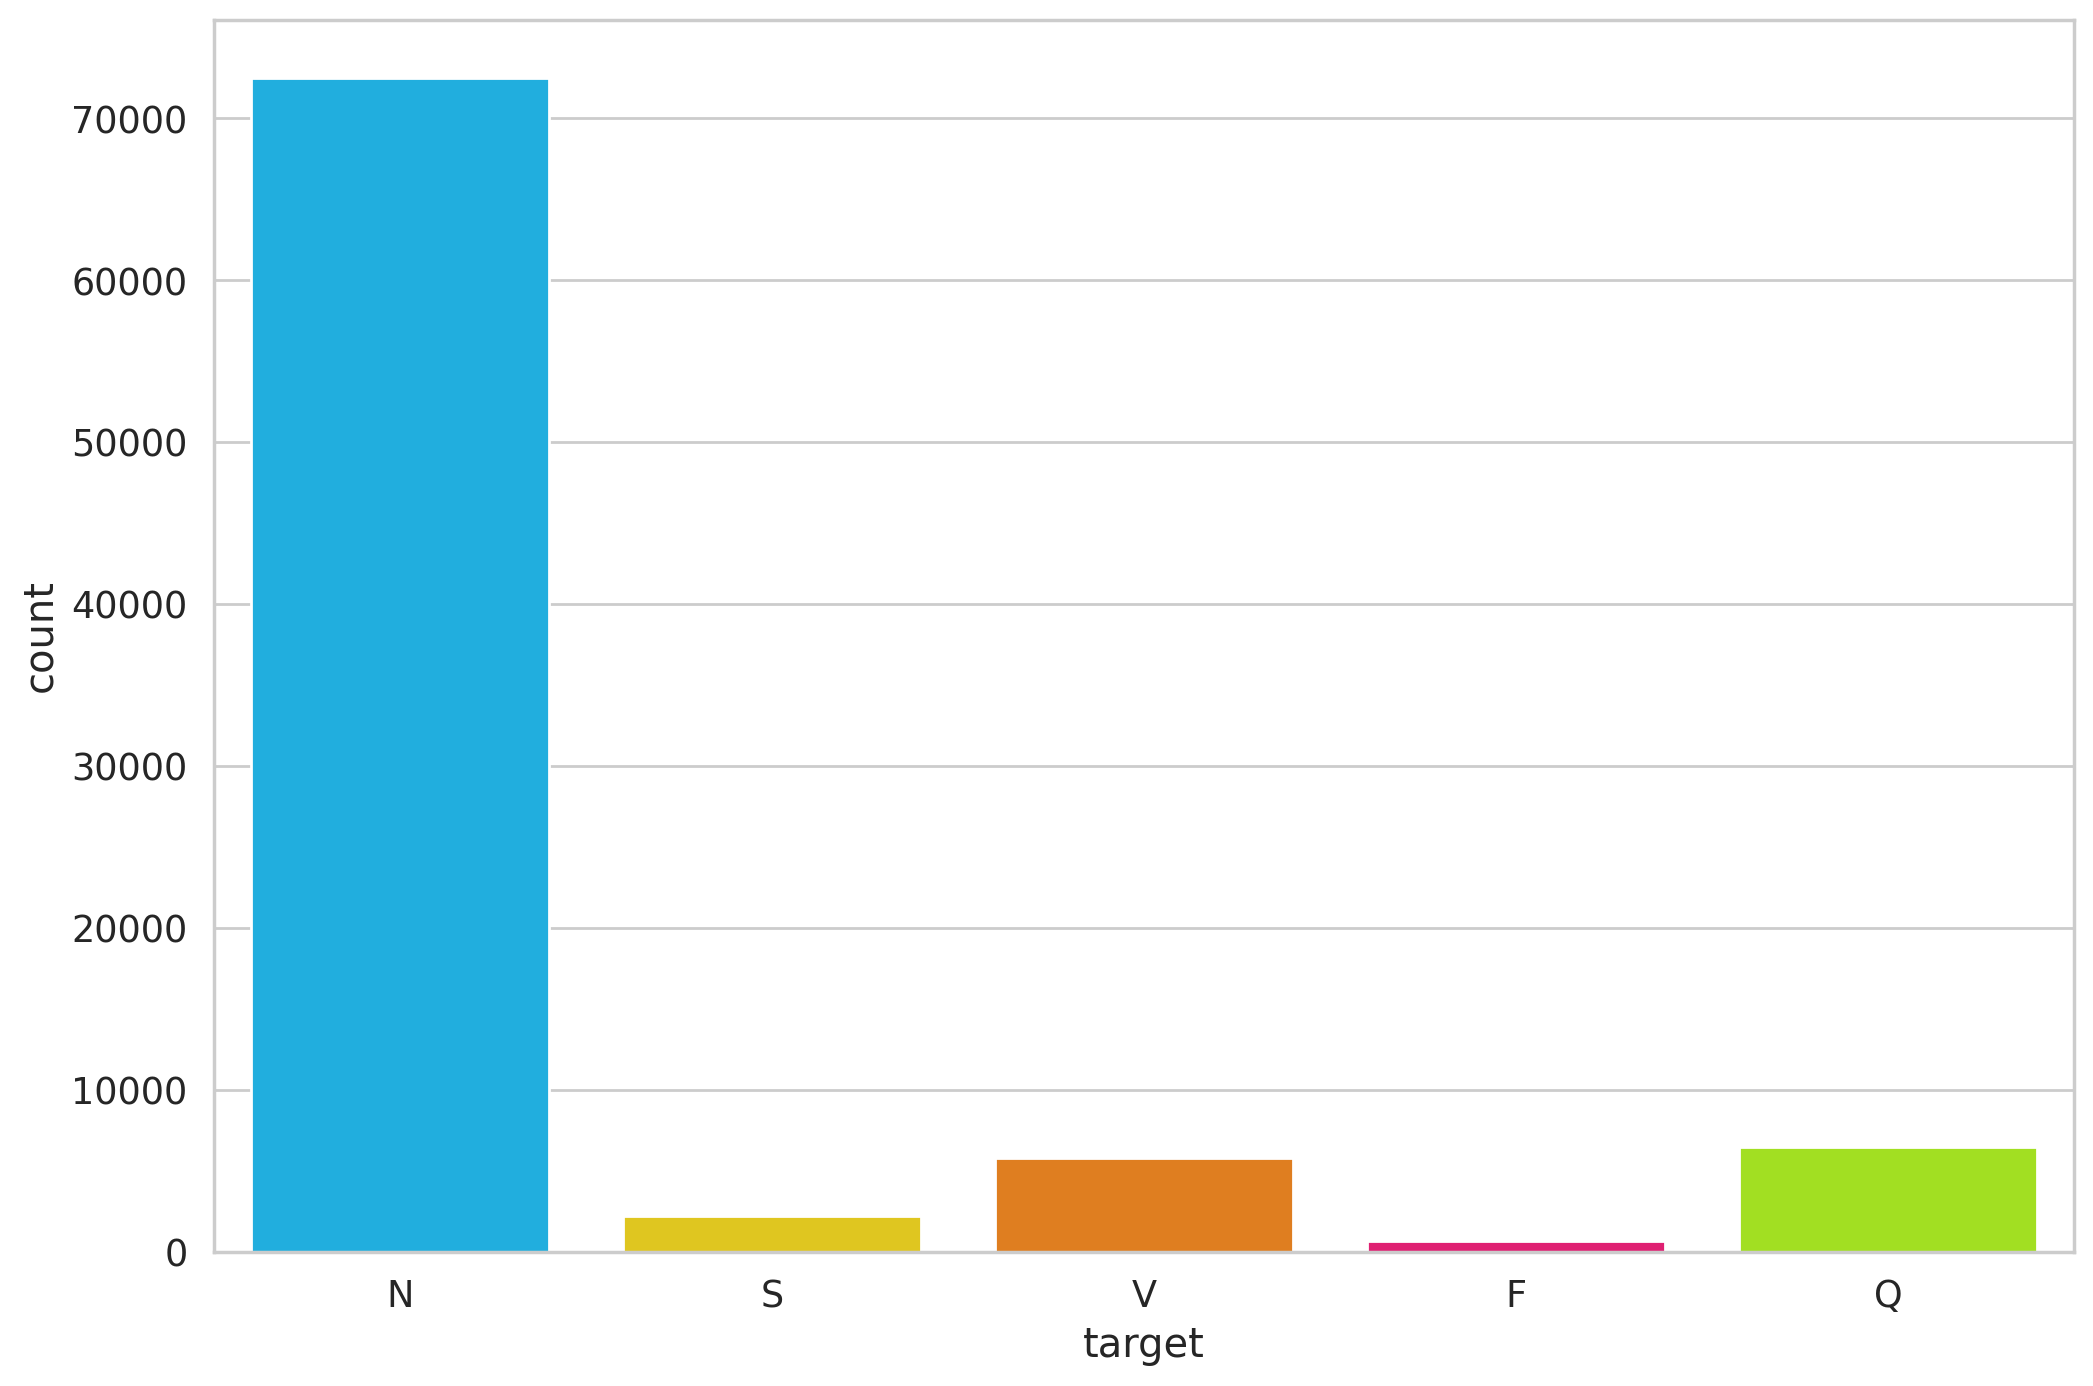

In [115]:
ax = sns.countplot(x='target', data=df_train_val)
ax.set_xticklabels(class_names);

In [116]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

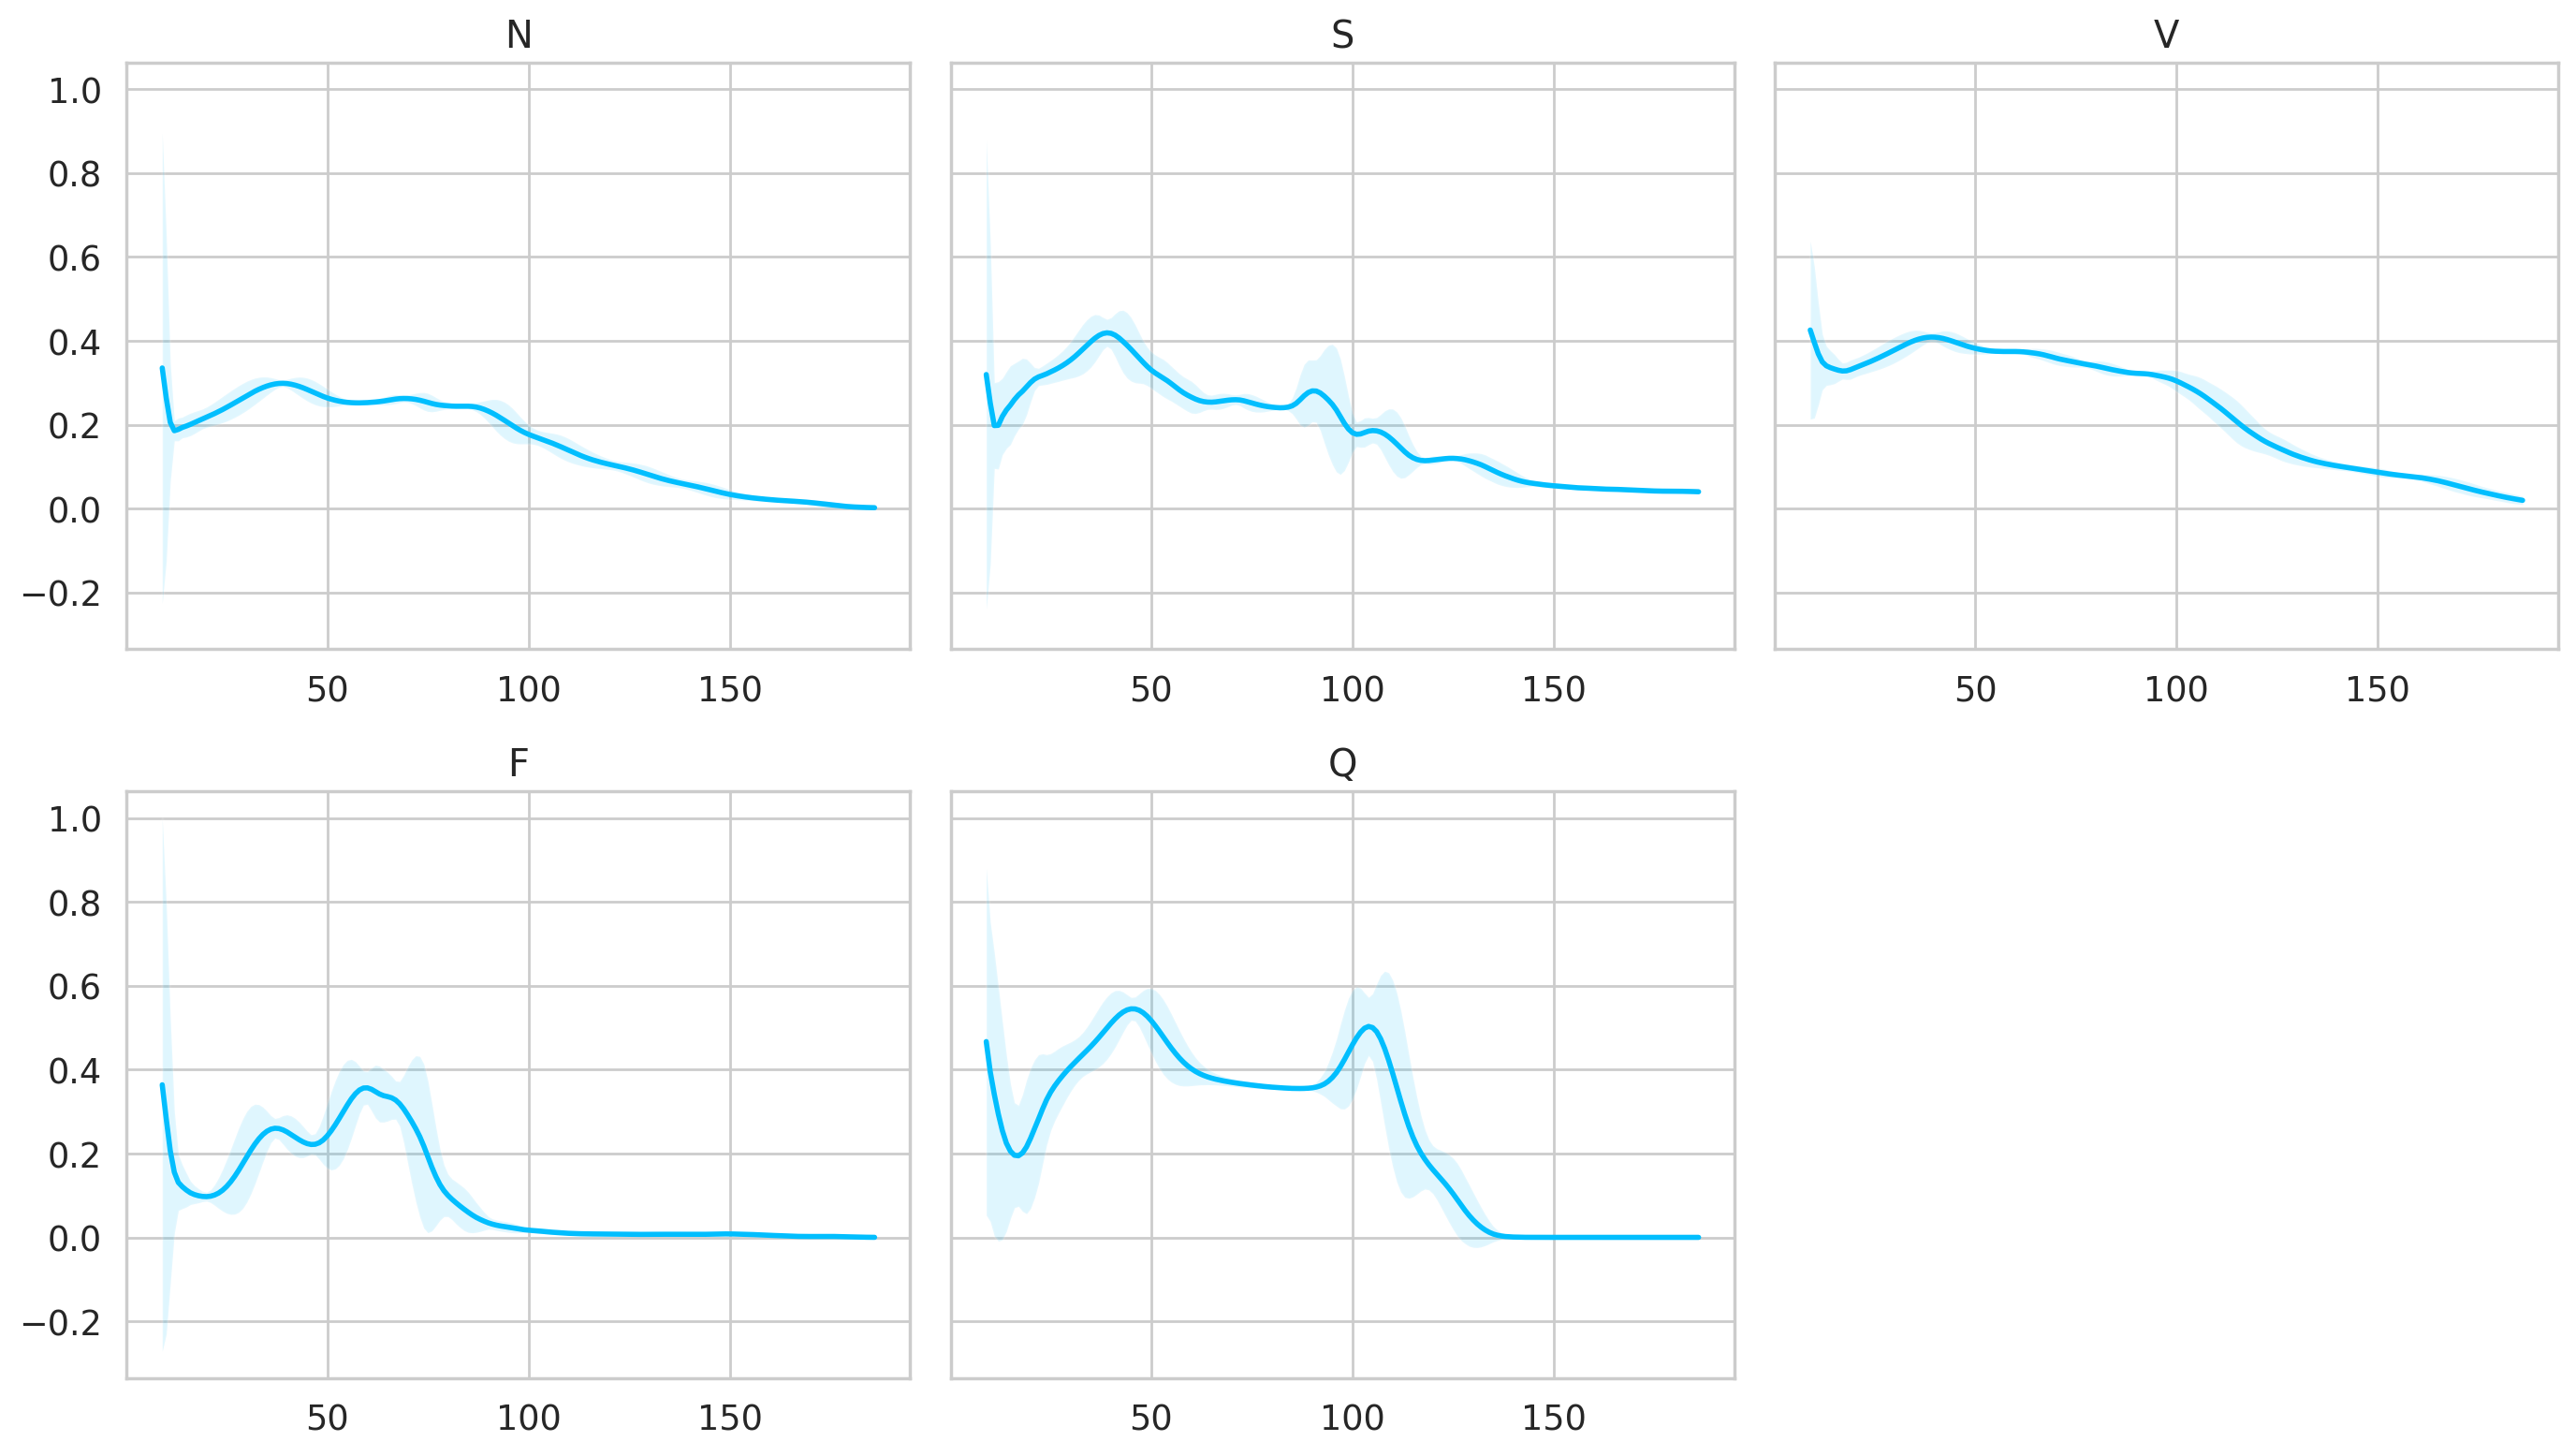

In [117]:
df = df_train_val
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

## LSTM-автоэнкодер

Задача [автоэнкодера](https://en.wikipedia.org/wiki/Autoencoder) заключается в том, чтобы получить некоторые входные данные, пропустить их через модель и получить реконструкцию входных данных. Реконструкция должна максимально соответствовать входным данным. Суть в том, чтобы использовать небольшое количество параметров, чтобы модель научилась создавать сжатое представление данных.

В некотором смысле, автоэнкодеры пытаются изучить только самые важные характеристики (сжатую версию) данных. Далее рассмотрим, как подавать данные временных рядов в автоэнкодер. Будем использовать несколько слоев LSTM (отсюда название LSTM-автоэнкодер), чтобы захватить временные зависимости в данных.

Чтобы классифицировать последовательность как нормальную или аномальную, выберем пороговое значение, выше которого сердечный цикл будет считаться ненормальным.

### Reconstruction Loss (потери при реконструкции)

При обучении автоэнкодера цель состоит в том, чтобы максимально точно реконструировать входные данные. Это делается путем минимизации функции потерь (как и при обучении с учителем). Эта функция потерь известна как *reconstruction loss*. Кросс-энтропия и среднеквадратичная ошибка являются распространенными примерами таких функций.

## Обнаружение аномалий в данных ЭКГ
Будем использовать нормальные сердечные циклы в качестве обучающих данных для нашей модели и оценивать ошибку реконструкции. Но сначала нужно подготовить данные.

### Предварительная обработка данных
Получим все нормальные сердечные сокращения и удалим столбец target:

In [118]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
print(normal_df.shape)

test_df = df_test[df_test.target == CLASS_NORMAL].drop(labels='target', axis=1)
print(test_df.shape)

(72471, 187)
(18118, 187)


Объединим все остальные классы и отметим их как аномалии:

In [119]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df_test = df_test[df_test.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df = pd.concat([anomaly_df, anomaly_df_test])
print(anomaly_df.shape)

(18857, 187)


Разделим нормальные примеры на обучающую, валидационную и тестовую выборки:

In [122]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.2,
  random_state=RANDOM_SEED
)

Нужно преобразовать примеры в тензоры, чтобы мы могли использовать их для обучения нашего автокодировщика. Напишем вспомогательную функцию для этого:

In [123]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Каждый временной ряд будет преобразован в 2D тензор формы *длина последовательности* (*sequence length*) x *количество признаков* (*number of features*) (140x1 в нашем случае).

Создадим требуемые наборы данных:

In [124]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

Создадим загрузчики данных:

In [221]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

test_normal_loader = DataLoader(
    test_normal_dataset,
    batch_size=1,
    shuffle=False
)

test_anomaly_loader = DataLoader(
    test_anomaly_dataset,
    batch_size=1,
    shuffle=False
)

### LSTM-автоэнкодер

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Архитектура автоэнкодера [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

In [134]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
      
    return hidden_n

Общая архитектура автокодировщика состоит из двух компонентов. *Энкодер* (*Encoder*), который сжимает входные данные, и *декодер* (*Decoder*), который пытается восстановить их.

Мы будем использовать LSTM-автокодировщик из [этого репозитория](https://github.com/shobrook/sequitur) с некоторыми небольшими изменениями. Задача нашей модели - восстанавливать данные временных рядов. Начнем с *энкодера* (*Encoder*).

*Энкодер* использует два слоя LSTM для сжатия входных данных временных рядов.

Далее, будем декодировать сжатое представление с помощью *декодера*:

In [135]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = torch.permute(x, (1, 0, 2))
    x = x.repeat(1, self.seq_len, 1)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)

    return self.output_layer(x)

Наш декодер содержит два слоя LSTM и выходной слой, который дает итоговую реконструкцию.

Теперь соберем всё в удобный для использования модуль:

In [222]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

## Обучение

Напишем вспомогательную функцию для процесса обучения:

In [224]:
def train_model(train_loader, val_loader, n_epochs):
    global best_model_wts
    global  history
    global model
    
    """
    Trains the model using Adam optimizer and a cosine annealing scheduler for smooth learning rate decay.

    Args:
        model: torch.nn.Module, the neural network to train
        train_loader: DataLoader, training data loader
        val_loader: DataLoader, validation data loader
        n_epochs: int, number of epochs to train
        device: torch.device, the device on which to train

    Returns:
        model (in eval mode): the best model by validation loss
        history: dict with 'train' and 'val' loss lists
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=n_epochs,
        eta_min=1e-3,
        last_epoch=-1
    )
    criterion = nn.L1Loss(reduction='sum').to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []

        for seq_true in train_loader:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item() / seq_true.size(0))

        model.eval()
        val_losses = []
        with torch.no_grad():
            for seq_true in val_loader:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item() / seq_true.size(0))

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        scheduler.step()

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        current_lr = optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch}/{n_epochs} - "
            f"train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, lr: {current_lr:.2e}"
        )

In [225]:
model = RecurrentAutoencoder(seq_len, n_features, 256)
model = model.to(device)

In [226]:
best_model_wts = None
history = {'train': [], 'val': []}

train_model(train_loader, val_loader, n_epochs=30)

model.load_state_dict(best_model_wts)
model = model.eval()

Epoch 1/30 - train_loss: 62.3135, val_loss: 24.6591, lr: 9.98e-03
Epoch 2/30 - train_loss: 25.5108, val_loss: 30.1557, lr: 9.90e-03
Epoch 3/30 - train_loss: 24.9264, val_loss: 25.3769, lr: 9.78e-03
Epoch 4/30 - train_loss: 24.3244, val_loss: 26.1956, lr: 9.61e-03
Epoch 5/30 - train_loss: 23.7798, val_loss: 21.9973, lr: 9.40e-03
Epoch 6/30 - train_loss: 29.4856, val_loss: 30.3198, lr: 9.14e-03
Epoch 7/30 - train_loss: 24.0688, val_loss: 26.1164, lr: 8.84e-03
Epoch 8/30 - train_loss: 23.8280, val_loss: 27.4532, lr: 8.51e-03
Epoch 9/30 - train_loss: 23.7673, val_loss: 26.4026, lr: 8.15e-03
Epoch 10/30 - train_loss: 24.0505, val_loss: 29.9446, lr: 7.75e-03
Epoch 11/30 - train_loss: 23.1619, val_loss: 24.9958, lr: 7.33e-03
Epoch 12/30 - train_loss: 22.2088, val_loss: 27.1753, lr: 6.89e-03
Epoch 13/30 - train_loss: 23.5661, val_loss: 22.0615, lr: 6.44e-03
Epoch 14/30 - train_loss: 23.8492, val_loss: 23.2023, lr: 5.97e-03
Epoch 15/30 - train_loss: 21.5378, val_loss: 23.3521, lr: 5.50e-03
Epoc

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, batch_first=True)
    (rnn2): LSTM(512, 256, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(256, 256, batch_first=True)
    (rnn2): LSTM(256, 512, batch_first=True)
    (output_layer): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [251]:
import json
with open('history.json', 'w') as f:
    json.dump(history, f)
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# import json
# with open('history.json', 'r') as f:
#     history = json.load(f)
# model.load_state_dict(torch.load('model_weights.pth', map_location='cuda'))

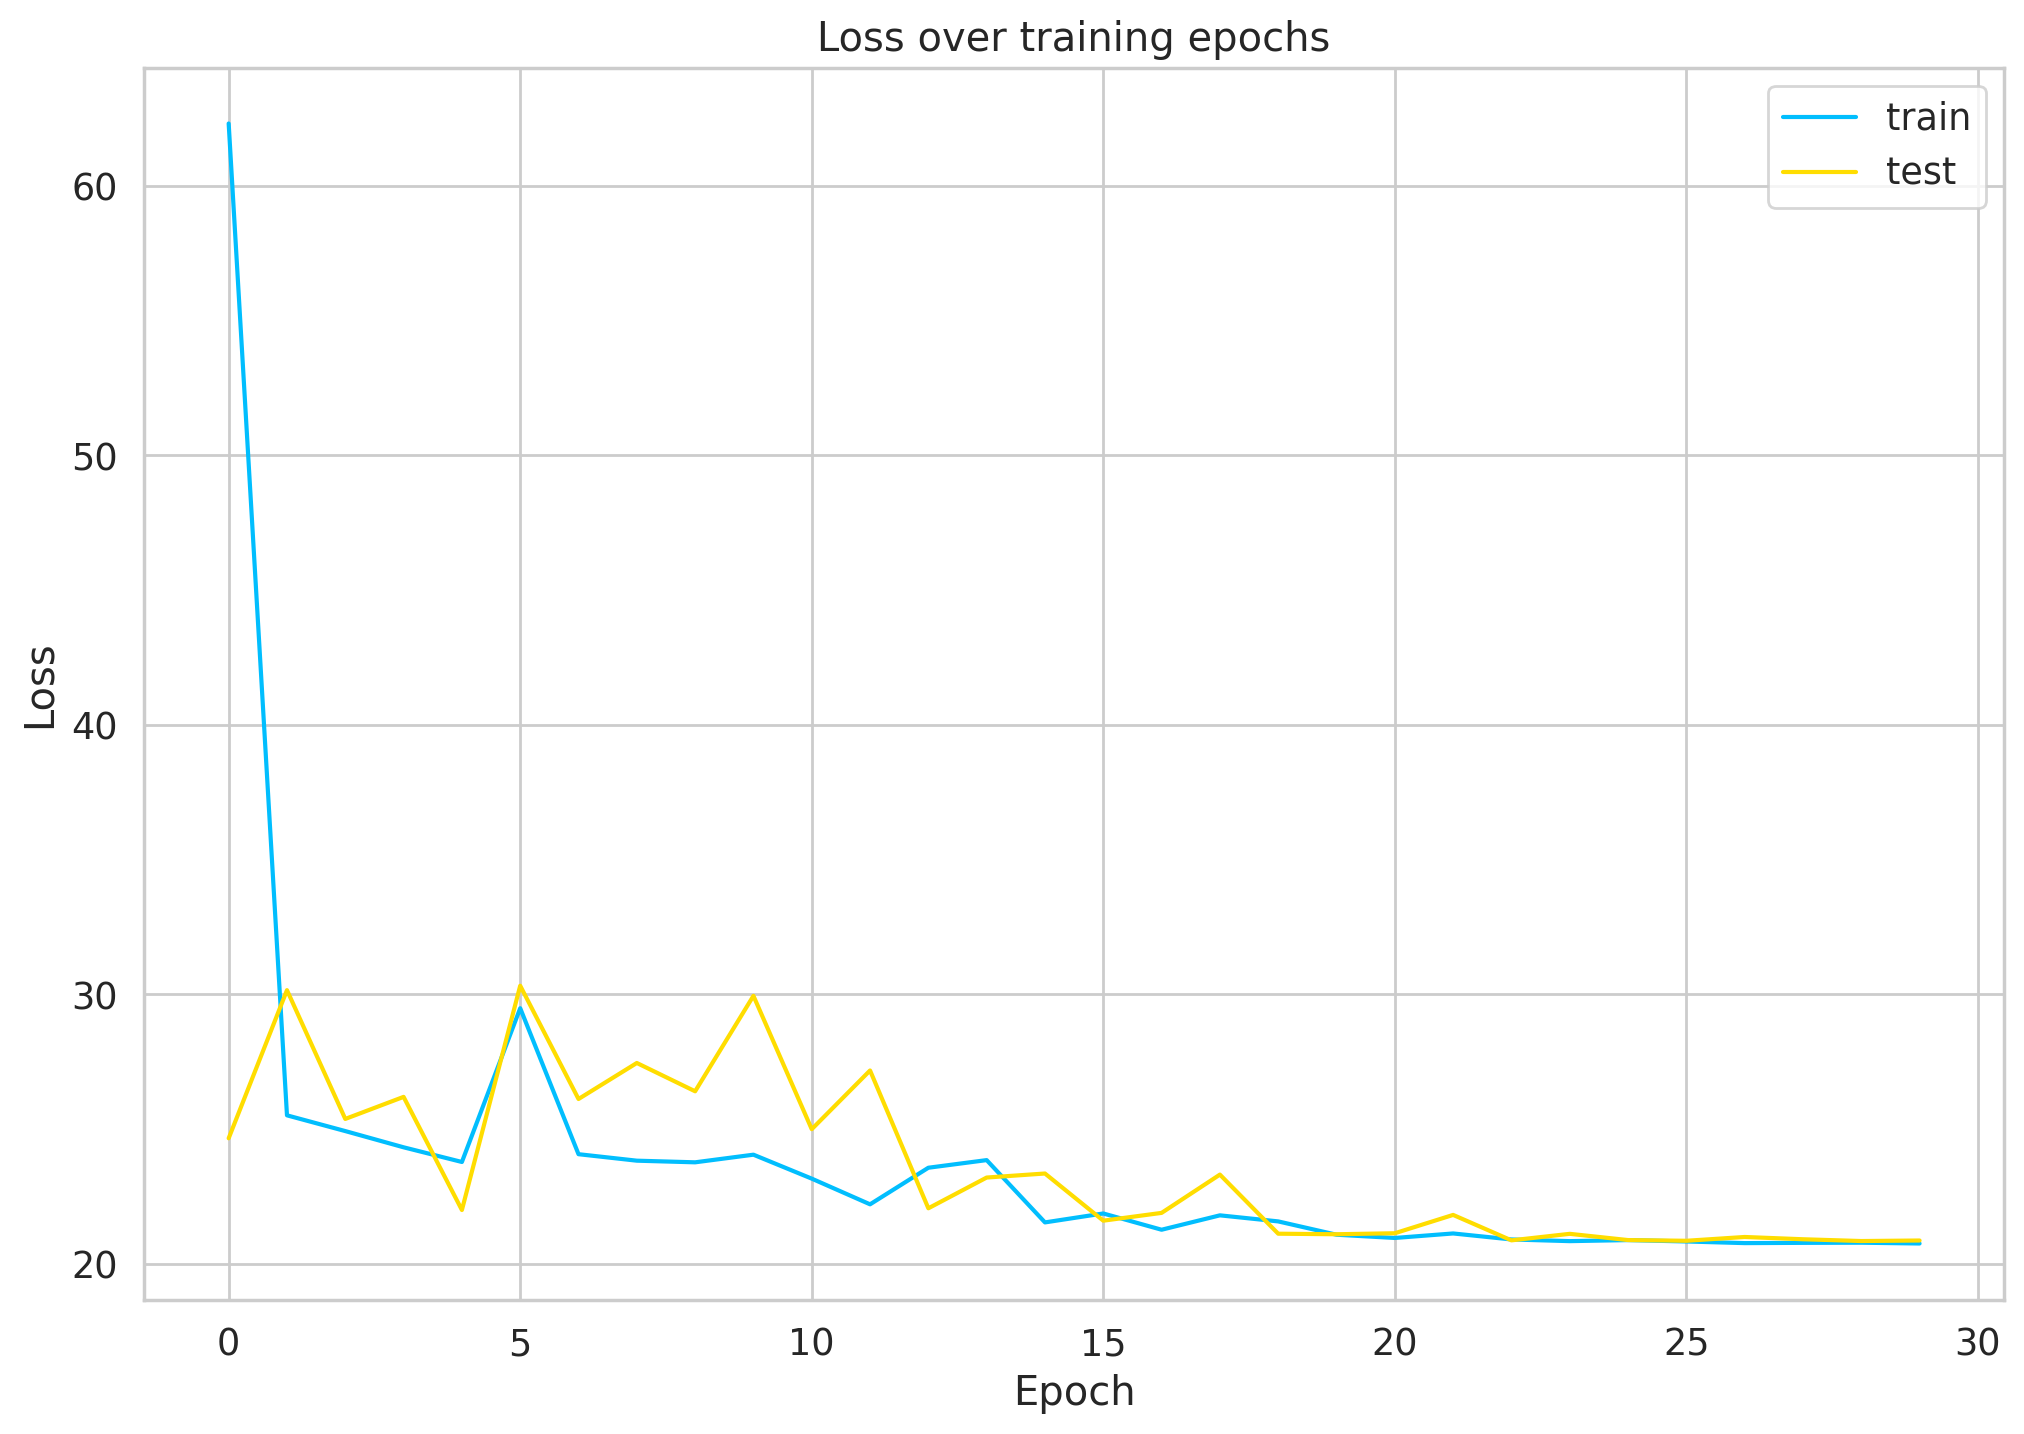

In [229]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

Наша модель обучается довольно хорошо. Похоже, что нам, возможно, понадобился бы больший валидационный набор для сглаживания результатов, но пока этого достаточно.

## Выбор порогового значения
Имея модель, можем взглянуть на ошибку реконструкции на обучающем наборе. Давайте начнем с написания вспомогательной функции для получения предсказаний нашей модели:

In [230]:
def predict(model, dataloader):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
    
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataloader:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Функция predict обрабатывает каждый пример в наборе данных и записывает предсказания и потери. Давайте получим потери и рассмотрим их:

/tmp/ipykernel_31/663717740.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


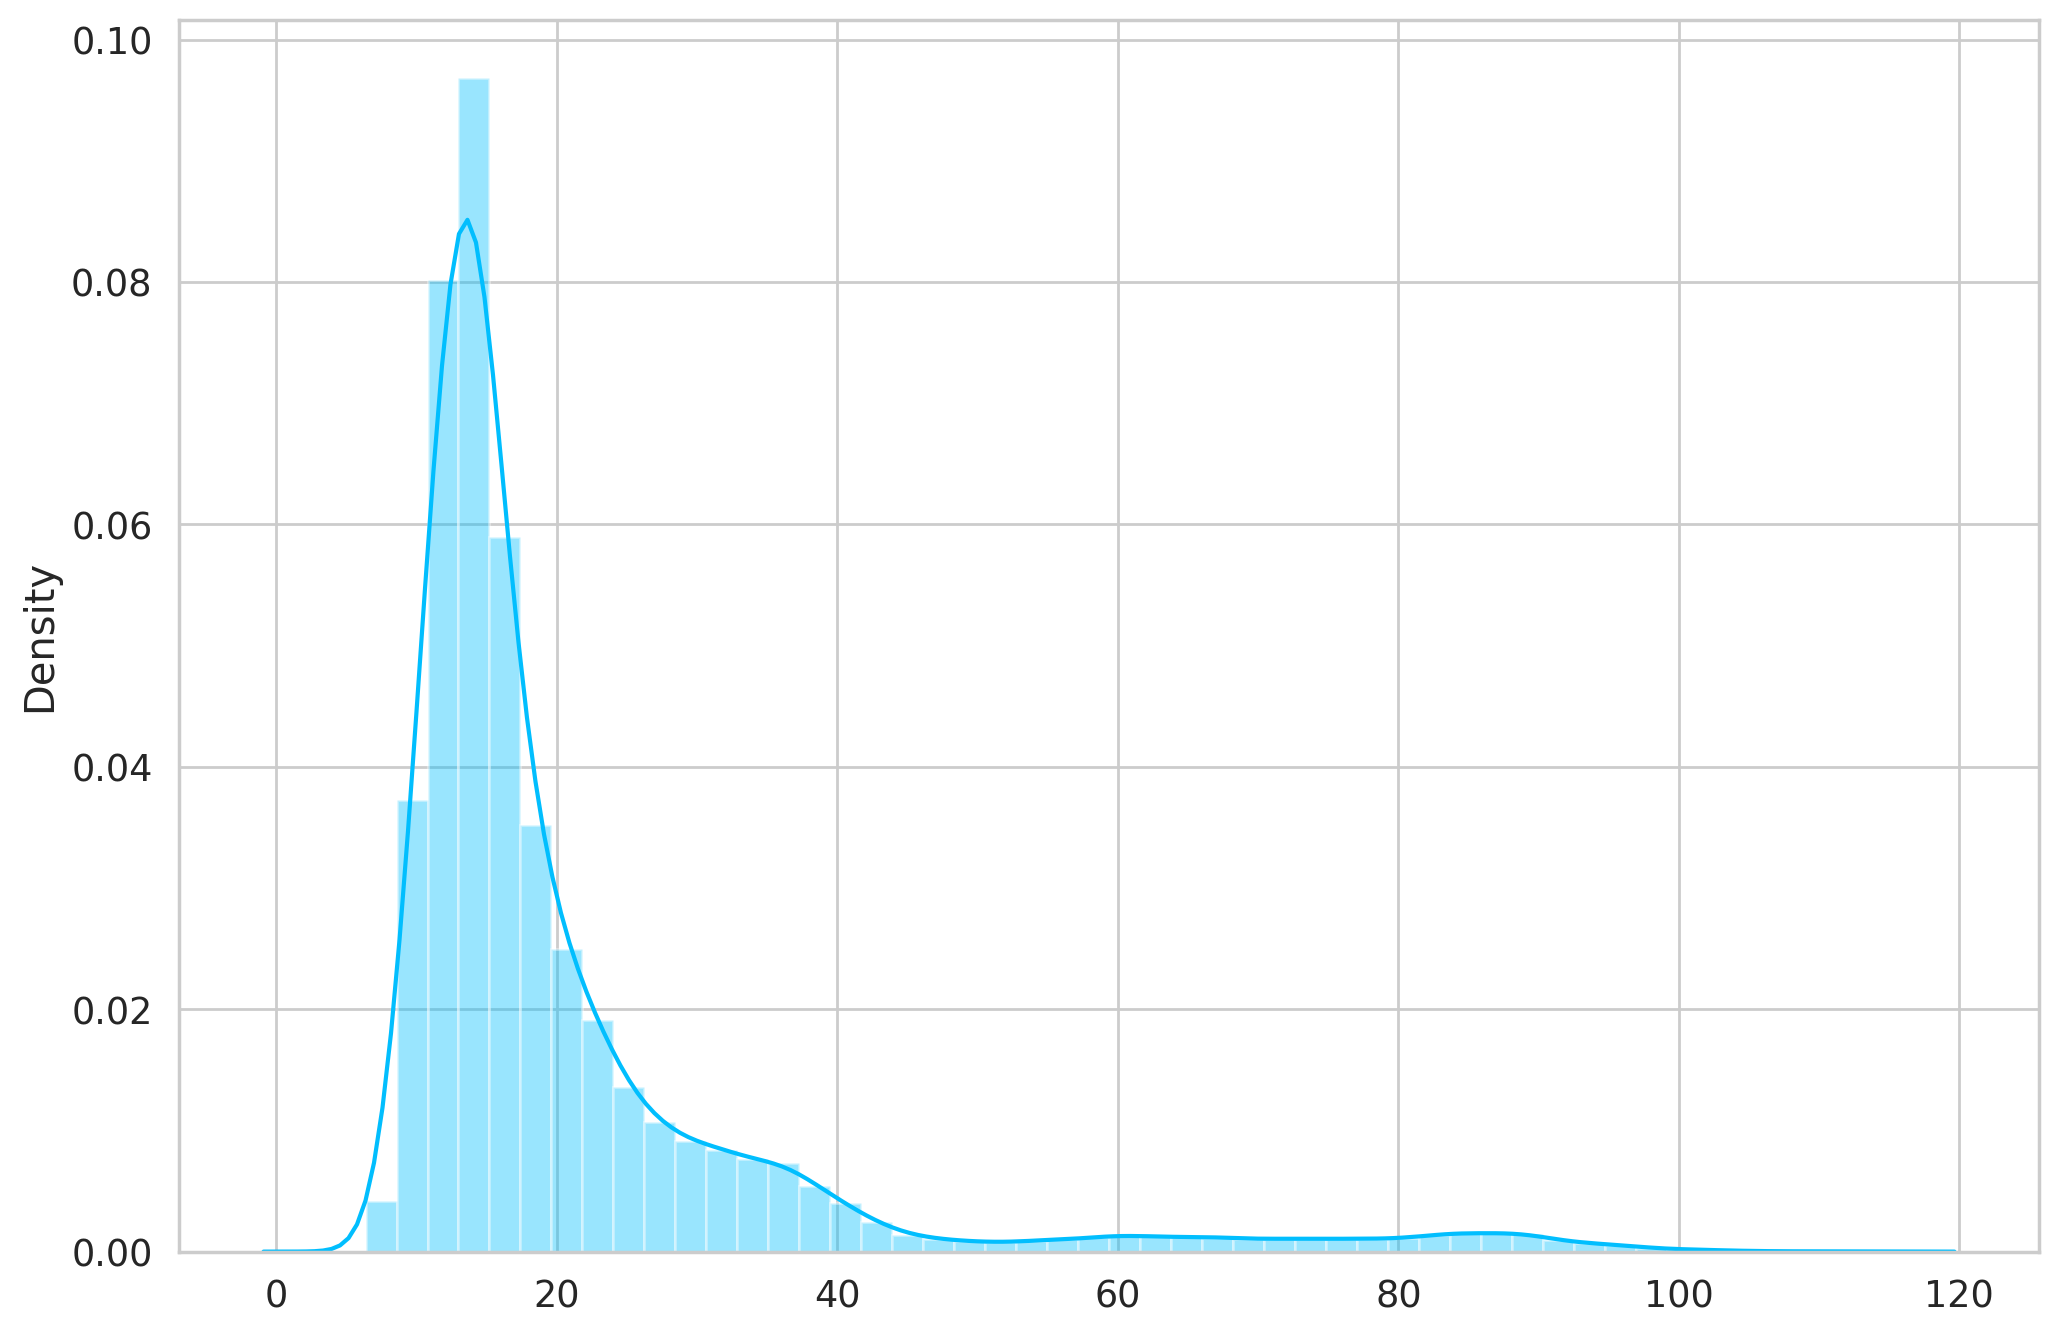

In [231]:
train_loader_one_element = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True
)

_, losses = predict(model, train_loader_one_element)

sns.distplot(losses, bins=50, kde=True);

In [248]:
THRESHOLD = 21

## Оценка
Используя пороговое значение, можно переформулировать проблему в простую задачу бинарной классификации:

- Если ошибка реконструкции для примера ниже порогового значения, мы классифицируем его как *нормальное* сердцебиение
- Если ошибка выше порогового значения, мы классифицируем его как *аномалию*

## Нормальные сердцебиения
Давайте проверим, насколько хорошо наша модель справляется с нормальными сердцебиениями. Мы будем использовать нормальные сердцебиения из тестового набора (которые модель ещё не видела):

/tmp/ipykernel_31/1135353705.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


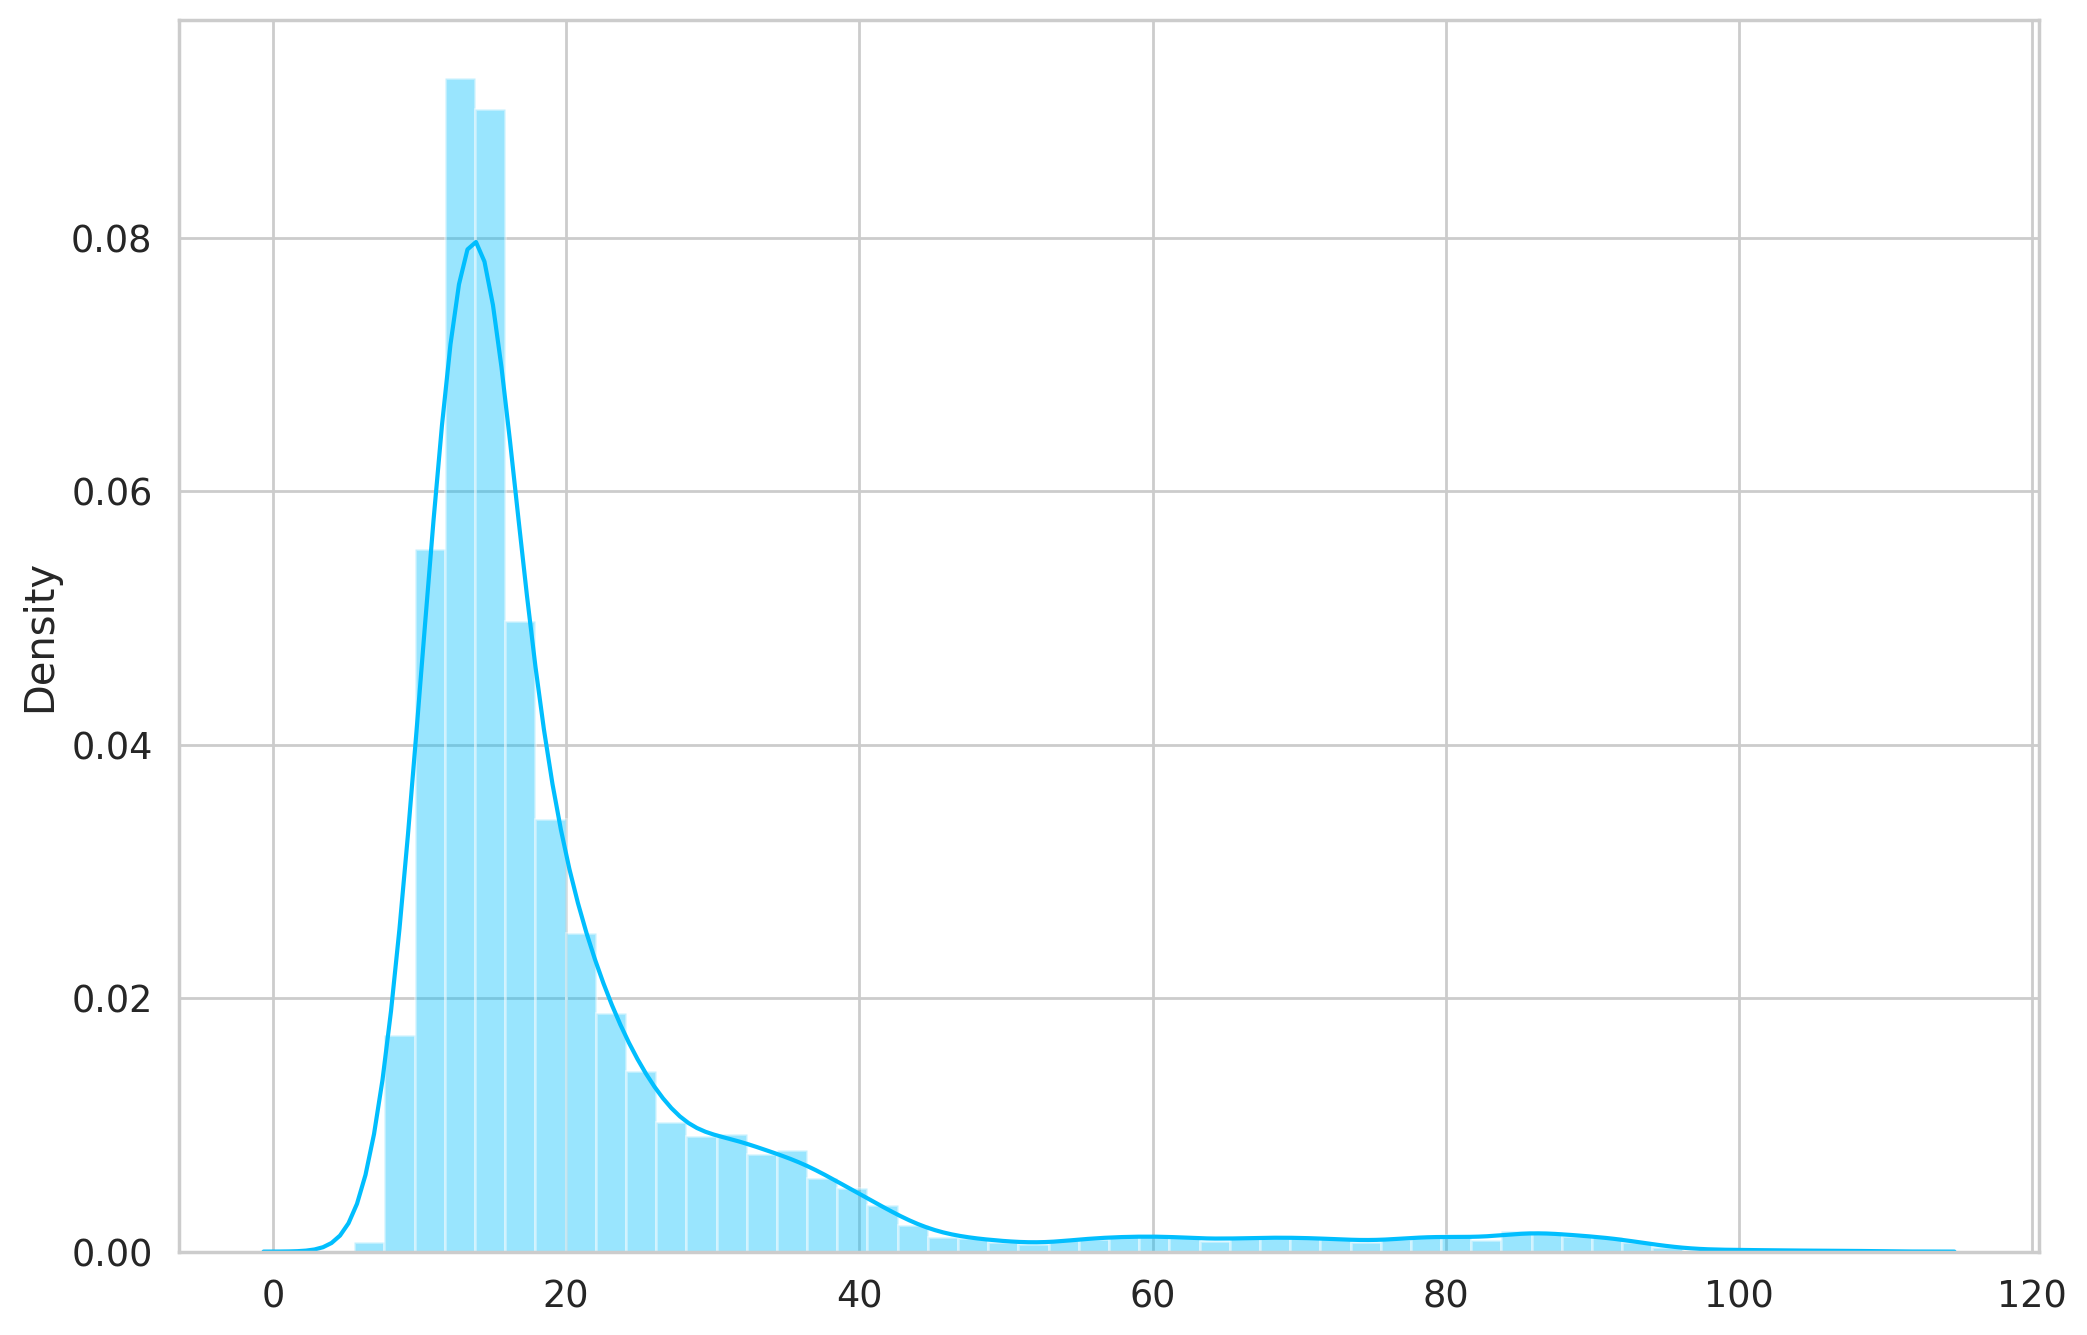

In [234]:
# Загрузчик test_normal_loader загружает по одному сигналу
predictions, pred_losses = predict(model, test_normal_loader)
sns.distplot(pred_losses, bins=50, kde=True);

Посчитаем правильные предсказания:

In [249]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_loader)}')
print(f'Accuracy on normal predictions: {correct/len(test_normal_loader)}')

Correct normal predictions: 6740/18118
Accuracy on normal predictions: 0.3720057401479192


### Аномалии

Сделаем то же самое с примерами аномалий, но их количество намного больше. Возьмем подмножество, которое имеет тот же размер, что и нормальные сердцебиения:

In [236]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

anomaly_loader = DataLoader(
    anomaly_dataset,
    batch_size=1,
    shuffle=False
)

Теперь мы можем получить предсказания нашей модели для подмножества аномалий:

/tmp/ipykernel_31/886031801.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


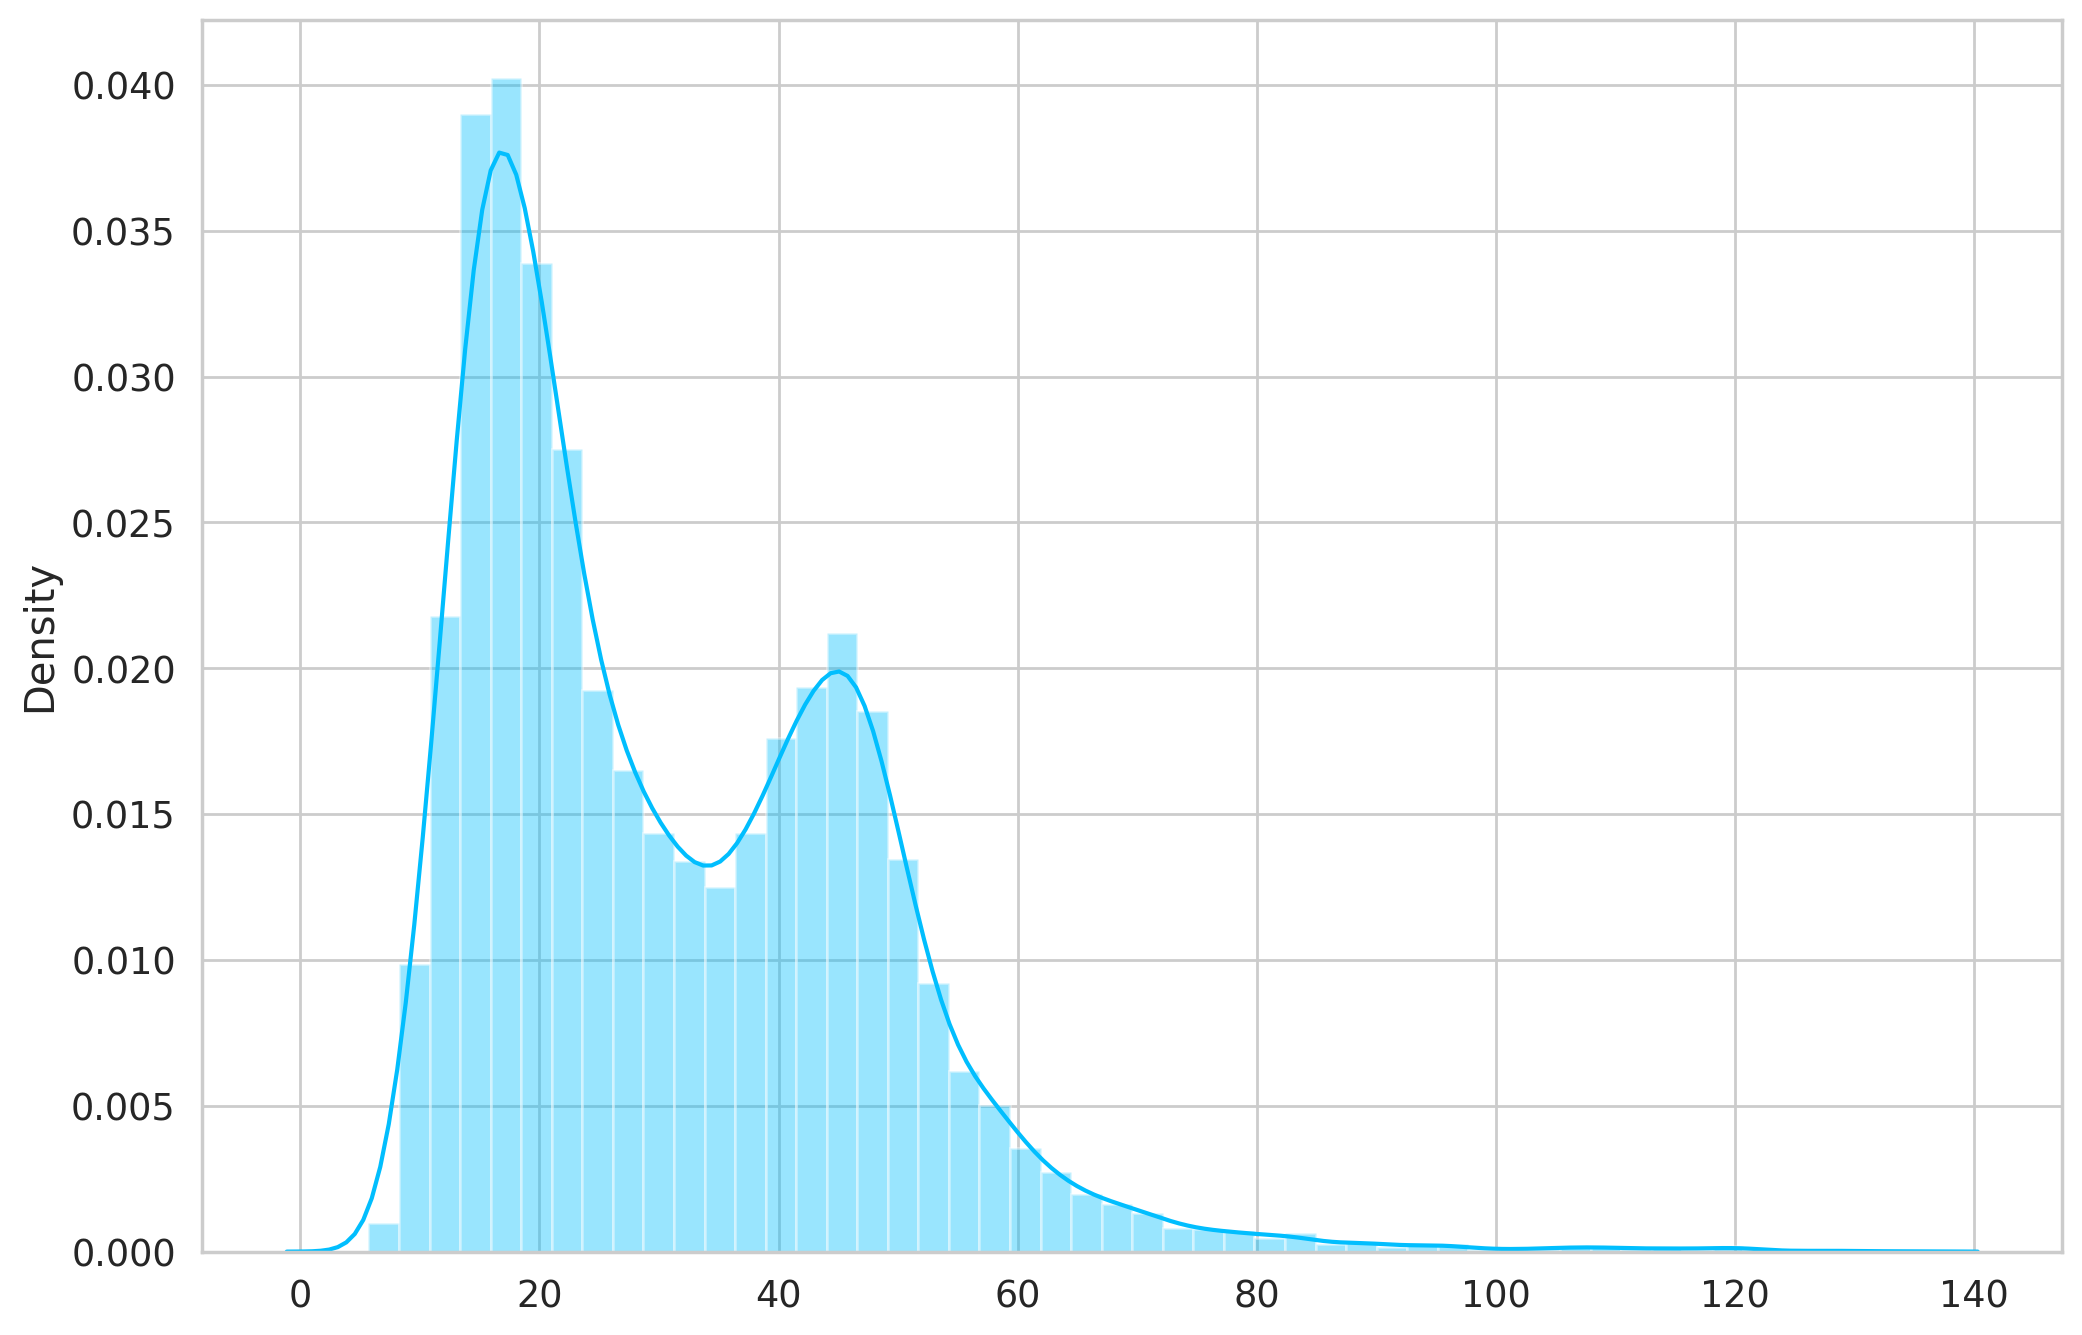

In [237]:
predictions, pred_losses = predict(model, anomaly_loader)
sns.distplot(pred_losses, bins=50, kde=True);

Наконец, подсчитаем количество примеров, превышающих порог (рассматриваемых как аномалии):

In [250]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_loader)}')
print(f'Accuracy on anomaly predictions: {correct/len(anomaly_loader)}')

Correct anomaly predictions: 11378/18118
Accuracy on anomaly predictions: 0.6279942598520808


Как мы видим, ошибка реконструкции на аномальных данных имеет две моды. Поскольку 

#### Анализ примеров
Можно наложить реальные и реконструированные значения временных рядов, чтобы увидеть, насколько они близки. Сделаем это для нескольких нормальных случаев и случаев с аномалиями:

In [182]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data[0], label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

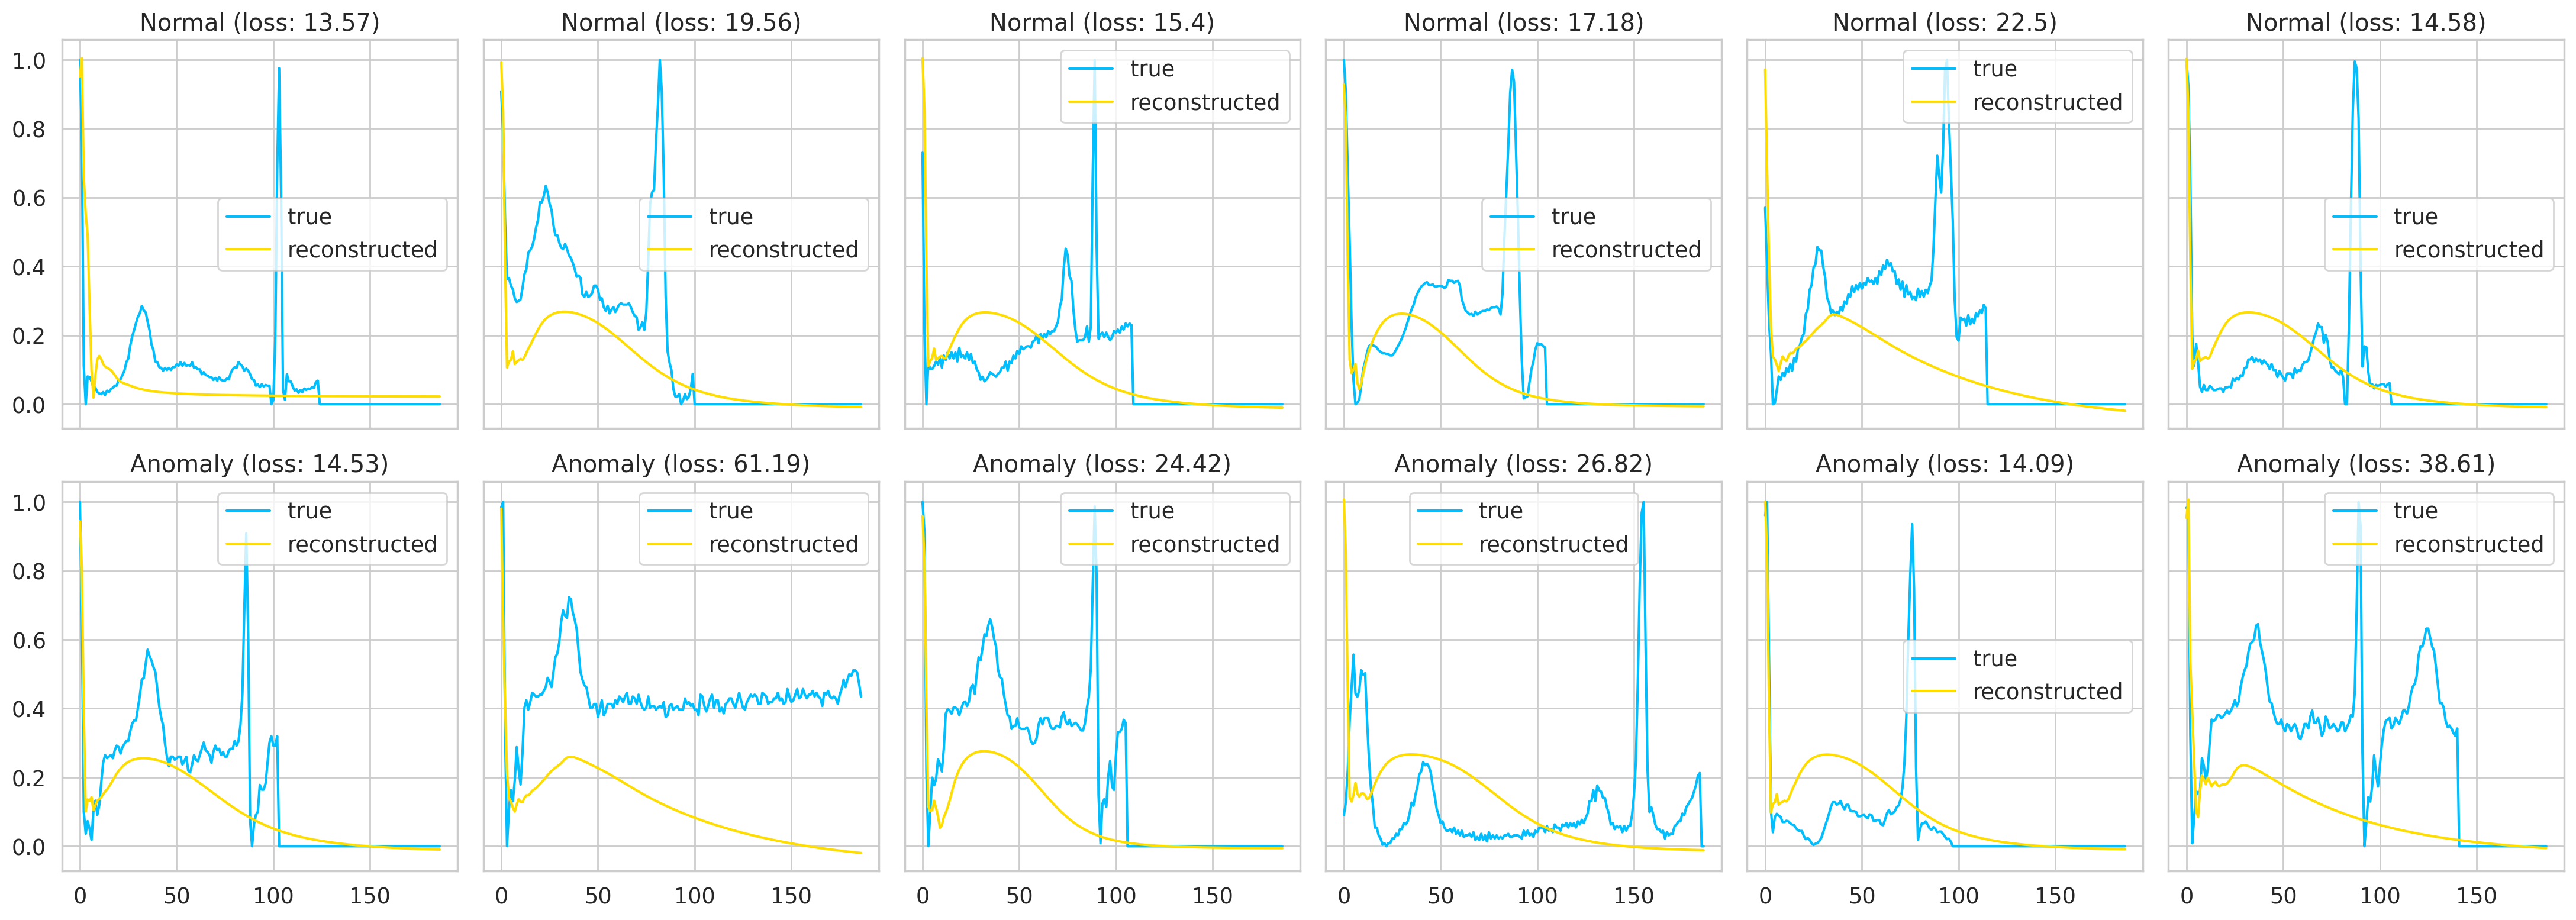

In [232]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)


test_normal_loader_one_element = DataLoader(
    test_normal_dataset[:6],
    batch_size=1,
    shuffle=False
)

test_anomaly_loader_one_element = DataLoader(
    test_anomaly_dataset[:6],
    batch_size=1,
    shuffle=False
)


for i, data in enumerate(test_normal_loader_one_element):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_loader_one_element):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

#### В данной работе научились обучать LSTM автоэнкодер для обнаружения аномалий. LSTM автоэнкодер обучается восстанавливать нормальные временные ряды, минимизируя ошибку - loss. Для аномальных данных эта ошибка должна быть выше. В целом нормальные данные имеют диапазон ошибки от 13.57 до 22.5, а аномальные от 14.9 до 61.19. Также мы здесь видим, что некоторые нормальные данные имеют более высокую ошибку, чем некотрые аномальные данные. В целом модель различает аномалии, тк мы видим более высокии значения лосса. Но в задачах классификации определить нормлаьные данные или аномальные будет тяжело из-за того, что лоссы пересекаются. Также можем посмотреть результаты реконструкции и исходных графиков. Мы видим что для нормальных данных реконструкция близка к исходным, в отличие от аномальных данных. На больших эпохах была бы видна большая различимость, однако здесь все упирается в производительность. 

## Краткие выводы к блокноту
В этом руководстве вы узнали, как создать LSTM-автокодировщик с помощью PyTorch и использовать его для обнаружения аномалий сердцебиения в данных ЭКГ.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

Вы научились:
- Подготавливать набор данных для обнаружения аномалий во временных рядах
- Создавать LSTM-автокодировщик с помощью PyTorch
- Обучать и оценивать вашу модель
- Выбирать порог для обнаружения аномалий
- Классифицировать новые примеры как нормальные или аномальные
- Хотя наши данные временных рядов являются одномерными (у нас только 1 признак), код должен работать для многомерных наборов данных (несколько признаков) с небольшими изменениями или без них.

## Ссылки, приведенные в исходном блокноте

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)

## Полезные материалы
- [Интерактивная визуализация детекции аномалий с помощью автоэнкодеров](https://anomagram.fastforwardlabs.com/#/)
- [Пример использования автоэнкодеров для детекции аномалий во временных рядах](https://www.luxoft.com/blog/advanced-anomaly-detection-deep-learning-pytorch)
- [Репозиторий с реализацией вариационного автоэнкодера для временных рядов](https://github.com/tejaslodaya/timeseries-clustering-vae)